Smaller Notebook, which focuses only on the creation of cross correlation matrices, for later usage

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pyhmc as phmc
import scipy.linalg as la


import struct

Nt=24
w, h = 3, Nt
n_smear = 1
n_op = 4
n_meas = 50


def E_mass(L,mass):
    return np.arccosh(np.cosh(mass) + 1 -np.cos( 2*np.pi/L) )


def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, np.transpose(a), rtol=rtol, atol=atol)

def corr_th(x, a,b,c,d):
    E= np.arccosh(2 - np.cos(2*np.pi/Nt))
    return a * np.cosh((x-Nt/2)*b) + c*np.cosh((x-Nt/2)*d)



def readfile(B_,Bphi_,B2_,BP2_,fn,kappa):
    b_l = w * 8
    ck = b_l*Nt*n_op
    Sm_ck = ck*n_smear
    with  open(fn,"rb" ) as f:
        fileContent =f.read()
        for n in range(n_meas):
            for ns in range(n_smear):
                for t in range(Nt):
                    B_[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+b_l*t:(Sm_ck*n)+(ck*ns)+(t+1)*b_l])
                    B2_[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+(b_l*Nt)+b_l*t:(Sm_ck*n)+(ck*ns)+(b_l*Nt)+(t+1)*b_l])
                    Bphi_[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+(b_l*Nt*2)+b_l*t:(Sm_ck*n)+(ck*ns)+(b_l*Nt*2)+(t+1)*b_l])
                    BP2_[n][ns][t]=struct.unpack("d"*3, fileContent[(Sm_ck*n)+(ck*ns)+(b_l*Nt*3)+b_l*t:(Sm_ck*n)+(ck*ns)+(b_l*Nt*3)+(t+1)*b_l])
    print("File have been read")


    '''
    B1=[]
    for n in range(n_meas):
        B1.append(B_[n][0][0])
    plt.plot(B1, label='B[0][0] kappa=%d '%kappa)
    plt.legend()
    plt.show
    '''
    
def cross_correlator(c_var,kappa):
    O = [[[0 for y in range(h)]for z in range(n_smear) ]for n in range(n_meas) ]
    O1 = [[[0 for y in range(h)]for z in range(n_smear) ]for n in range(n_meas) ]
    O2 = [[[0 for y in range(h)]for z in range(n_smear) ]for n in range(n_meas) ]
    O3 = [[[0 for y in range(h)]for z in range(n_smear) ]for n in range(n_meas) ]
    O_sq = [[[0 for y in range(h)]for z in range(n_smear) ] for n in range(n_meas) ]
    
    
    for n in range(n_meas):
        for ns in range(n_smear):
            for t in range(Nt):
                for k in range(2):
                    O[n][ns][t] += B[n][ns][t][k]/2
                    O1[n][ns][t] += B1[n][ns][t][k]/2
                    O3[n][ns][t] += B3[n][ns][t][k]/2
                O_sq[n][ns][t] = O[n][ns][t]*O[n][ns][t] 
                for k in range(2):
                    O2[n][ns][t] += (O_sq[n][ns][t]*B[n][ns][t][k])/2
                    
    
    c_mat = [[0 for i in range(n_smear*n_op) ]for j in range(n_smear*n_op) ]
    for n in range(n_meas):
        for i in range(n_smear):
            for j in range(n_smear):
                for t in range(Nt):
                    for t_pr in range(Nt):
                            c_var[n][i][j][t]                     += (O [n][i][t_pr] * O [n][j][(t_pr+t)%Nt] + O [n][i][(t_pr+t)%Nt] * O [n][j][t_pr]) / 2
                            c_var[n][i+n_smear][j+n_smear][t]     += (O1[n][i][t_pr] * O1[n][j][(t_pr+t)%Nt] + O1[n][i][(t_pr+t)%Nt] * O1[n][j][t_pr]) / 2
                            c_var[n][i+2*n_smear][j+2*n_smear][t] += (O2[n][i][t_pr] * O2[n][j][(t_pr+t)%Nt] + O2[n][i][(t_pr+t)%Nt] * O2[n][j][t_pr]) / 2
                            c_var[n][i+3*n_smear][j+3*n_smear][t] += (O3[n][i][t_pr] * O3[n][j][(t_pr+t)%Nt] + O3[n][i][(t_pr+t)%Nt] * O3[n][j][t_pr]) / 2
                            c_var[n][i][j+n_smear][t]             += (O [n][i][t_pr] * O1[n][j][(t_pr+t)%Nt] + O [n][i][(t_pr+t)%Nt] * O1[n][j][t_pr]) / 2
                            c_var[n][i][j+2*n_smear][t]           += (O [n][i][t_pr] * O2[n][j][(t_pr+t)%Nt] + O [n][i][(t_pr+t)%Nt] * O2[n][j][t_pr]) / 2
                            c_var[n][i][j+3*n_smear][t]           += (O [n][i][t_pr] * O3[n][j][(t_pr+t)%Nt] + O [n][i][(t_pr+t)%Nt] * O3[n][j][t_pr]) / 2
                            c_var[n][i+n_smear][j][t]             += (O1[n][i][t_pr] * O [n][j][(t_pr+t)%Nt] + O1[n][i][(t_pr+t)%Nt] * O [n][j][t_pr]) / 2
                            c_var[n][i+2*n_smear][j][t]           += (O2[n][i][t_pr] * O [n][j][(t_pr+t)%Nt] + O2[n][i][(t_pr+t)%Nt] * O [n][j][t_pr]) / 2
                            c_var[n][i+3*n_smear][j][t]           += (O3[n][i][t_pr] * O [n][j][(t_pr+t)%Nt] + O3[n][i][(t_pr+t)%Nt] * O [n][j][t_pr]) / 2
                            c_var[n][i+n_smear][j+2*n_smear][t]   += (O1[n][i][t_pr] * O2[n][j][(t_pr+t)%Nt] + O1[n][i][(t_pr+t)%Nt] * O2[n][j][t_pr]) / 2
                            c_var[n][i+n_smear][j+3*n_smear][t]   += (O1[n][i][t_pr] * O3[n][j][(t_pr+t)%Nt] + O1[n][i][(t_pr+t)%Nt] * O3[n][j][t_pr]) / 2
                            c_var[n][i+2*n_smear][j+3*n_smear][t] += (O2[n][i][t_pr] * O3[n][j][(t_pr+t)%Nt] + O2[n][i][(t_pr+t)%Nt] * O3[n][j][t_pr]) / 2
                            c_var[n][i+2*n_smear][j+n_smear][t]   += (O2[n][i][t_pr] * O1[n][j][(t_pr+t)%Nt] + O2[n][i][(t_pr+t)%Nt] * O1[n][j][t_pr]) / 2
                            c_var[n][i+3*n_smear][j+n_smear][t]   += (O3[n][i][t_pr] * O1[n][j][(t_pr+t)%Nt] + O3[n][i][(t_pr+t)%Nt] * O1[n][j][t_pr]) / 2
                            c_var[n][i+3*n_smear][j+2*n_smear][t] += (O3[n][i][t_pr] * O2[n][j][(t_pr+t)%Nt] + O3[n][i][(t_pr+t)%Nt] * O2[n][j][t_pr]) / 2
    print("cross correlators filled")
    
    plt.figure(num=None, figsize=(8, 6), dpi=160, facecolor='w', edgecolor='k')
    for ns in range(n_smear):
        C=[]
        for n in range(n_meas):
            C.append(c_var[n][0][ns][ns])
        plt.scatter(x = list(range(n_meas)),y=C,label='C[0][%d][%d] kappa=%f '%(ns,ns,kappa))
        plt.legend()
        plt.show
    
    
def cross_corr_stat(c_res,c,kappa):
    #f = open('matrix.txt', 'w')
    #f1 = open('matrix_err.txt', 'w')
    c_mat = [[0 for i in range(n_smear*n_op) ]for j in range(n_smear*n_op) ]
    c_mat_err = [[0 for i in range(n_smear*n_op) ]for j in range(n_smear*n_op) ]
    c_res[0] = [[[0 for t in range(Nt)]for i in range(n_smear*n_op) ]for j in range(n_smear*n_op)  ]
    #c_res[0] = np.mean(c,axis =0 )
    for t in range(Nt):
        for i in range(n_smear*n_op):
            for j in range(n_smear*n_op):
                #c_res[0][i][j][t] =0 
                for n in range(n_meas):
                    c_res[0][i][j][t] += (c[n][i][j][t]+c[n][j][i][t] )/(2*n_meas) 
    
    #c_mat = [[0 for i in range(n_smear*n_op) ]for j in range(n_smear*n_op) ]
    #for t in range(Nt):
    #    for i in range(n_smear*n_op):
    #        for j in range(n_smear*n_op):
    #            c_mat[i][j] = c_res[0][i][j][t]
    #    print('t= '+str(t)+str(check_symmetric(c_mat)))
    #print(c_res[0][0][0])
    c_res[1] = np.std(c,axis =0 )
    c_res[2] = [[[0 for t in range(Nt)]for i in range(n_smear*n_op) ]for j in range(n_smear*n_op)  ]
    for i in range(n_smear*n_op):
        for j in range(n_smear*n_op):
            for t in range(Nt):
                vec = []
                for n in range(n_meas):
                    vec.append(float(c[n][i][j][t]))
                c_res[2][i][j][t] = phmc.integrated_autocorr6(np.array(vec),6)
                #c_res[2][ns][t] =1
                print(c_res[2][i][j][t])
                c_res[1][i][j][t] = c_res[1][i][j][t]* np.sqrt(c_res[2][i][j][t]/n_meas)
    with open('cross/matrix_np_L%d_k%f.txt' %(Nt,kappa),'w')  as outfile:
        with open('cross/matrix_np_L%d_k%f_err.txt'%(Nt,kappa),'w') as errfile:
            for t in range(Nt):
                for i in range(n_smear*n_op):
                    for j in range(n_smear*n_op):
                        c_mat[i][j]=float(c_res[0][i][j][t])
                        c_mat_err[i][j]=float(c_res[1][i][j][t])
                        
                c_mat =np.array(c_mat)
                c_mat_err =np.array(c_mat_err)
        
                #np.savetxt(outfile ,c_mat,fmt='%.6f')
                #outfile.write('# New time slice\n')
                #np.savetxt(errfile ,c_mat_err,fmt='%.6f')
                #errfile.write('# New time slice\n')
               
    
    print("Averages and uncertainties obtained")
  
B = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ] for n in range(n_meas) ]
B1 = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ]for n in range(n_meas) ]
B2 = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ] for n in range(n_meas) ]
B3 = [[[[0 for x in range(w)] for y in range(h)]for z in range(n_smear) ] for n in range(n_meas)]

C_var= [[[[0 for y in range(h)]for i in range(n_smear*n_op) ]for j in range(n_smear*n_op) ] for n in range(n_meas) ]
C_var_res = [[[0 for j in range(n_smear) ]for i in range(n_smear) ] for y in range (3) ]


def var_analysis_stat(kappa):
    filename = "Frodo/output_run24_Nt%d_Nx%d_Ny%d_Nz%d_B4.000000_K%f_L1.000000_n1200.bin" % (Nt,Nt,Nt,Nt,kappa)
    #filename = "O1minus_output_files_new/output_Nt32_Nx32_Ny32_Nz32_B4.000000_K0.550000_L1.000000_full.bin"
    readfile(B,B1,B2,B3,filename,kappa)                 
    cross_correlator(C_var,kappa)      
   # cross_corr_stat(C_var_res,C_var,kappa)
    
    

File have been read
cross correlators filled
File have been read
cross correlators filled


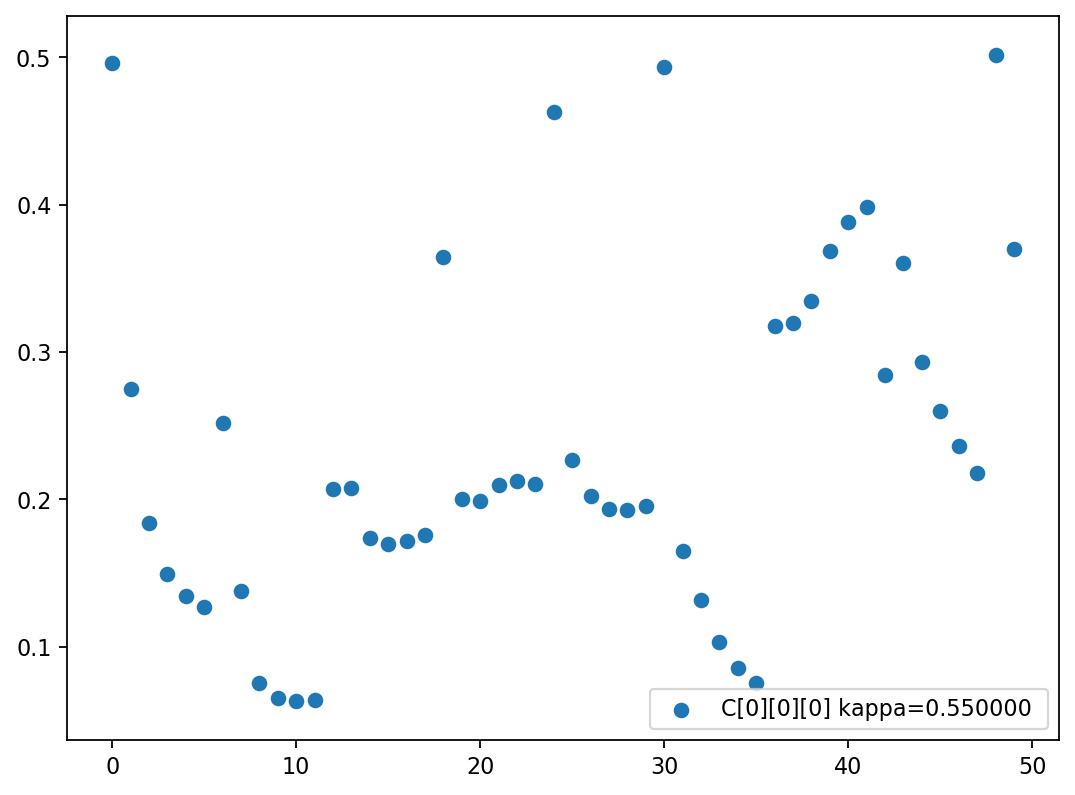

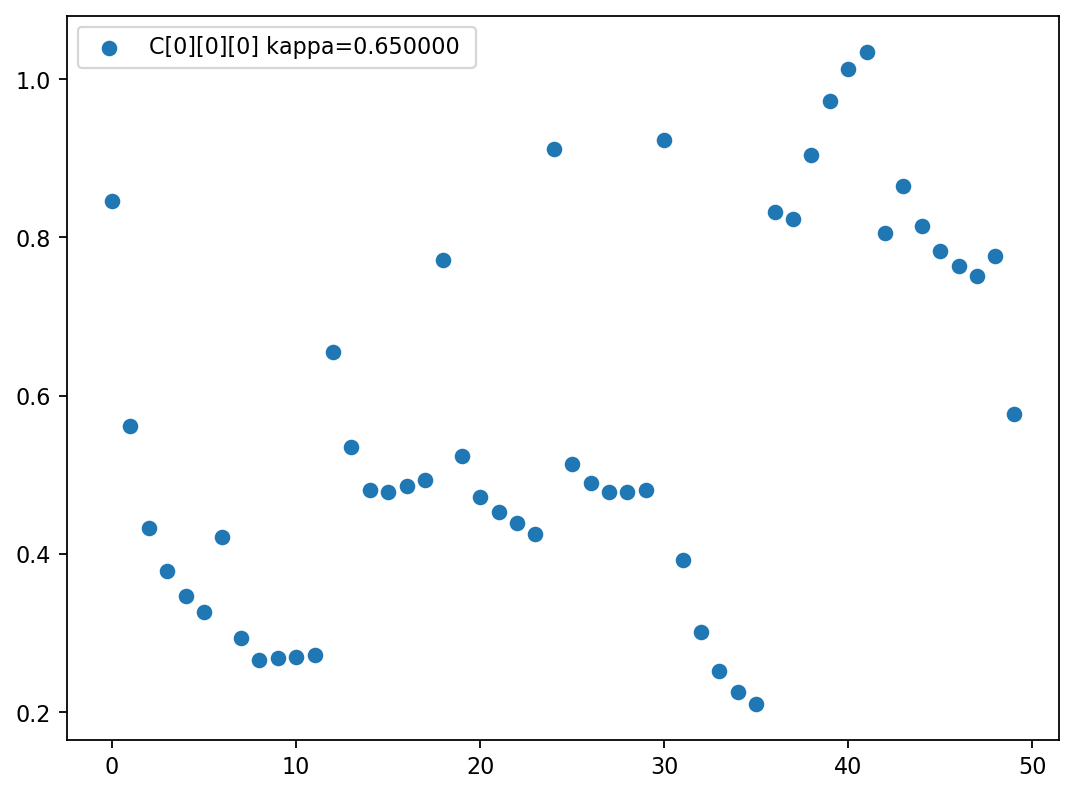

In [6]:
for k in range(2):
    kappa = 0.55+ k*0.1
    var_analysis_stat(kappa)